In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
path=[]
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'

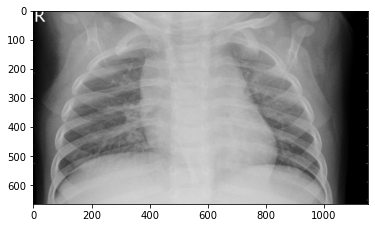

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
img = cv.imread(path[2])
plt.imshow(img)
path[2]

In [4]:
normal = []
pneu = []

for img in path:
    if "PNEUMONIA" in img:
        pneu.append(img)
    elif "NORMAL" in img:
        normal.append(img)

In [5]:
print("Total normal images: ", len(normal))
print("Total Pneumonia images: ", len(pneu))
print("Total images: ", len(normal) + len(pneu))


Total normal images:  4755
Total Pneumonia images:  12825
Total images:  17580


In [6]:
virus = []
bacteria = []
for img in pneu:
    if "bacteria" in img:
        bacteria.append(img)
    elif "virus" in img:
        virus.append(img)

In [7]:
print("Total Pneumonia images with Virus: ", len(virus))
print("Total Pneumonia images with Bacteria: ", len(bacteria))

Total Pneumonia images with Virus:  4479
Total Pneumonia images with Bacteria:  8340


In [8]:
def preprocessor(data):
    temp = []
    for img in data:
        img = cv.imread(img)
        if type(img) == np.ndarray:
            img1 = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
            img2 = cv.blur(img1, (3, 3))
            temp.append(cv.resize(img2, (32, 32)))
    return temp

In [9]:
normal_reshaped = preprocessor(normal)

In [10]:
bacteria_reshaped = preprocessor(bacteria)

In [11]:
virus_reshaped = preprocessor(virus)

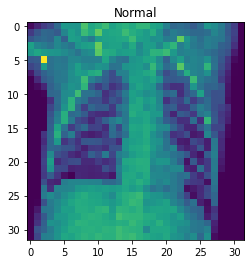

In [12]:
plt.title("Normal")
plt.imshow(normal_reshaped[2])

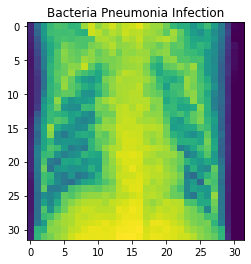

In [28]:
plt.title("Bacteria Pneumonia Infection")
plt.imshow(bacteria_reshaped[0])

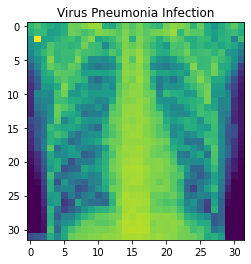

In [29]:
plt.title("Virus Pneumonia Infection")
plt.imshow(virus_reshaped[0])

In [13]:
n_train = normal_reshaped[:int((80/100)*len(normal_reshaped))] #0 : 80 normal-train
b_train = bacteria_reshaped[:int((80/100)*len(bacteria_reshaped))]
v_train = virus_reshaped[:int((80/100)*len(virus_reshaped))]

y_train = [1]*len(n_train)+[0]*len(b_train)+[2]*len(v_train)

In [14]:
n_test = normal_reshaped[int((80/100)*len(normal_reshaped)):]
b_test = bacteria_reshaped[int((80/100)*len(bacteria_reshaped)):]
v_test = virus_reshaped[int((80/100)*len(virus_reshaped)):]

y_test = [1]*len(n_test) + [0]*len(b_test) + [2]*len(v_test)

In [15]:
normal_scaled = np.array(n_train)/255
bacteria_scaled = np.array(b_train)/255
virus_scaled = np.array(v_train)/255

normal_scaled_t = np.array(n_test)/255
bacteria_scaled_t = np.array(b_test)/255
virus_scaled_t = np.array(v_test)/255


In [16]:
X_train = np.array(list(normal_scaled) + list(bacteria_scaled) + list(virus_scaled))
X_test = np.array(list(normal_scaled_t) + list(bacteria_scaled_t) + list(virus_scaled_t))

In [17]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [18]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,1)),
    layers.MaxPool2D(pool_size=2),
    
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(3, activation='softmax')
    
])
model._name = "OzeNet"
model.summary()


Model: "OzeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0    

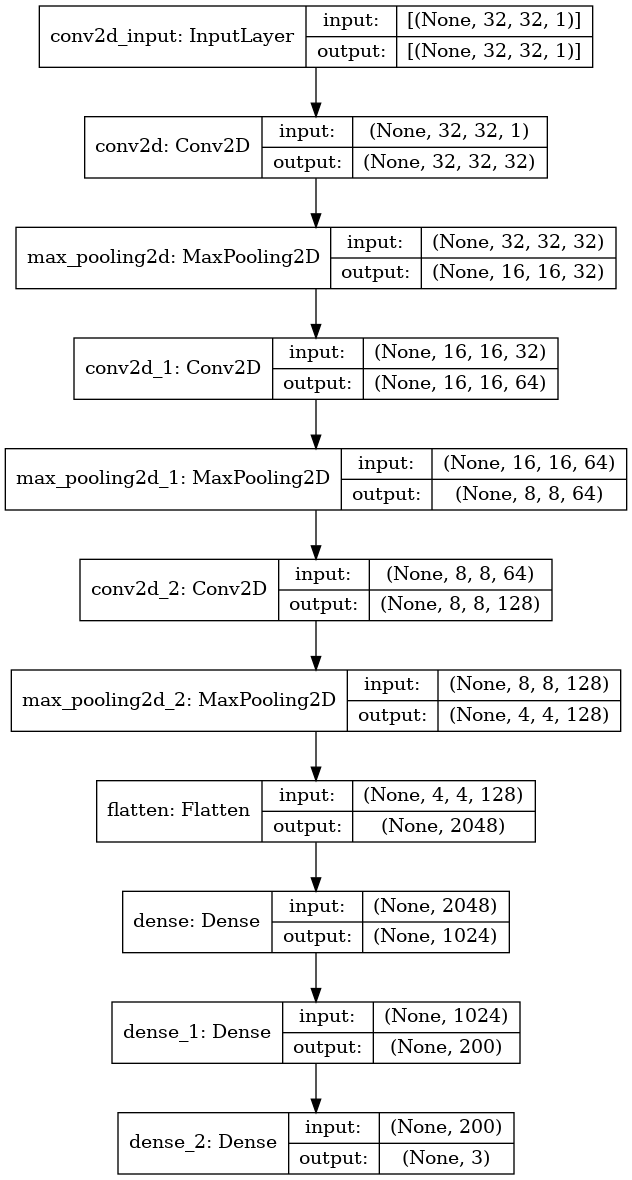

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
model.compile(optimizer = 'adam', metrics=['accuracy'], loss = 'sparse_categorical_crossentropy')

In [22]:
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
293/293 [==============================] - 14s 5ms/step - loss: 0.6619 - accuracy: 0.7054 - val_loss: 0.5608 - val_accuracy: 0.7590
Epoch 2/20
293/293 [==============================] - 1s 4ms/step - loss: 0.5006 - accuracy: 0.7905 - val_loss: 0.5005 - val_accuracy: 0.7769
Epoch 3/20
293/293 [==============================] - 1s 4ms/step - loss: 0.4557 - accuracy: 0.8087 - val_loss: 0.4765 - val_accuracy: 0.8020
Epoch 4/20
293/293 [==============================] - 1s 4ms/step - loss: 0.4284 - accuracy: 0.8166 - val_loss: 0.4239 - val_accuracy: 0.8148
Epoch 5/20
293/293 [==============================] - 1s 4ms/step - loss: 0.3892 - accuracy: 0.8368 - val_loss: 0.3814 - val_accuracy: 0.8413
Epoch 6/20
293/293 [==============================] - 1s 4ms/step - loss: 0.3559 - accuracy: 0.8532 - val_loss: 0.3415 - val_accuracy: 0.8494
Epoch 7/20
293/293 [==============================] - 1s 4ms/step - loss: 0.3142 - accuracy: 0.8703 - val_loss: 0.3250 - val_accuracy: 0.8579
Epoch

In [30]:
evaluation_result = model.evaluate(X_test, y_test)

74/74 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.9552


In [34]:
print(f"The accuracy of this model is: {round(evaluation_result[1]*100, 2)}")

The accuracy of this model is: 95.52


In [35]:
print(f"The loss of this model is: {round(evaluation_result[0]*100, 2)}")

The loss of this model is: 12.16


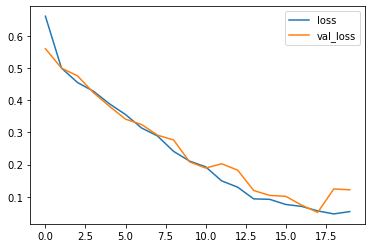

In [26]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
plt.savefig('loss_plot.png')

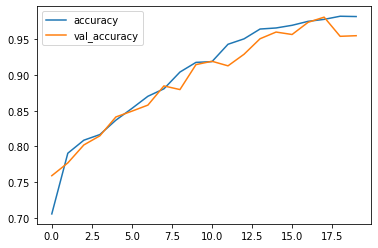

In [27]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.savefig('acc_plot.png')